**ID Student**

#  yousef_158719 _C3
#  johnny_154825 _C2
#   maha_153554 _C2
#   Abdulrahman_asaad_136880_C3
#   khaled_157968_C2

# #Install and import required libraries

In [1]:
!pip install nltk
!pip install tabulate

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
import string
from tabulate import tabulate
import numpy as np

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Part 1: Text Preprocessing

In [2]:
categories = ['sci.space', 'rec.sport.baseball', 'comp.graphics']
data = fetch_20newsgroups(subset='train',categories=categories,
                         remove=('headers', 'footers', 'quotes'))

docs = data.data
print("Number of documents:", len(docs))
print("Categories:", data.target_names,"\n")

#----------------------------
#  Preprocessing function
#----------------------------
def preprocess_text(text):
    if not text or text.strip() == "":
        return ""

    # 1. Lowercasing
    text = text.lower()

    # 2. Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation +
                                        '0123456789'))

    # 3. Tokenization
    tokens = word_tokenize(text)

    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    custom_stop = {'subject', 'edu', 'com', 'http', 'www'}
    tokens = [word for word in tokens if word not in stop_words and
              word not in custom_stop]

    # 5. Remove short words (length < 2)
    tokens = [word for word in tokens if len(word) > 2]

    # 6. Stemming, Lemmatization
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(lemmatizer.lemmatize(w)) for w in tokens]

    # 7. Join back to string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# -----------------------------
# Test example (as required)
# -----------------------------
print("TESTING WITH REQUIRED EXAMPLE:\n")

# Original example from the project description
original_example = "NASA's Space Shuttle launched into Orbit successfully."

# Apply preprocessing
cleaned_example = preprocess_text(original_example)

# Display results in table format
table_data = [
    ["Original", original_example],
    ["Cleaned", cleaned_example]
]

print(tabulate(table_data, headers=["Step", "Example Text"], tablefmt="grid"),"\n")

# -----------------------------
# Apply preprocessing to all documents
# -----------------------------
print("PREPROCESSING ALL DOCUMENTS...")
preprocessed_docs = [preprocess_text(doc) for doc in docs]
print("Preprocessing completed!", len(preprocessed_docs), "documents processed.")
print("Sample preprocessed document:", preprocessed_docs[0][:75] + "...")

Number of documents: 1774
Categories: ['comp.graphics', 'rec.sport.baseball', 'sci.space'] 

TESTING WITH REQUIRED EXAMPLE:

+----------+--------------------------------------------------------+
| Step     | Example Text                                           |
+==========+========================================================+
| Original | NASA's Space Shuttle launched into Orbit successfully. |
+----------+--------------------------------------------------------+
| Cleaned  | nasa space shuttl launch orbit success                 |
+----------+--------------------------------------------------------+ 

PREPROCESSING ALL DOCUMENTS...
Preprocessing completed! 1774 documents processed.
Sample preprocessed document: grey level imag mean item bit imag work doesnt work bit screen screen inten...


# **[ Part 2: Boolean Model]**

In [4]:
# ======================================
# PART 2: BOOLEAN MODEL (CLEAN & CORRECTED)
# ======================================

from tabulate import tabulate

# ------------------------------------------------
# 1. Build inverted index from tokenized documents
# ------------------------------------------------
def build_inverted_index(preprocessed_docs):
    inverted_index = {}
    for doc_id, text in enumerate(preprocessed_docs):
        if not text:
            continue
        tokens = text.split()
        for term in tokens:
            inverted_index.setdefault(term, set()).add(doc_id)
    return inverted_index

inverted_index = build_inverted_index(preprocessed_docs)
print("\nPART 2: BOOLEAN MODEL")
print(f"Inverted index built for {len(preprocessed_docs)} documents.")
print("Sample entries:\n")
for term in list(inverted_index.keys())[:12]:
    print(f"'{term}': {list(inverted_index[term])[:10]}...")

# ------------------------------------------------
# 2. Boolean retrieval with proper precedence
# ------------------------------------------------
def boolean_retrieve(query_expression, inverted_index, total_docs):
    all_docs = set(range(total_docs))
    operators = {"and", "or", "not"}

    # Tokenize while preserving Boolean operators
    raw_tokens = query_expression.lower().split()

    # Preprocess only non-operator tokens
    tokens = []
    for t in raw_tokens:
        if t in operators:
            tokens.append(t)
        else:
            clean = preprocess_text(t).strip()
            if clean:
                tokens.append(clean)

    # Shunting-yard like handling for precedence: NOT > AND > OR
    def apply_op(op, left, right=None):
        if op == "and":
            return left & right
        if op == "or":
            return left | right
        if op == "not":
            return all_docs - left
        return set()

    def get_docs(term):
        return inverted_index.get(term, set())

    # Evaluate expression left to right with precedence
    # Step 1: handle NOT
    i = 0
    processed = []
    while i < len(tokens):
        if tokens[i] == "not" and i + 1 < len(tokens) and tokens[i+1] not in operators:
            negated = apply_op("not", get_docs(tokens[i+1]))
            processed.append(negated)
            i += 2
        elif tokens[i] not in operators:
            processed.append(get_docs(tokens[i]))
            i += 1
        else:
            processed.append(tokens[i])
            i += 1

    # Step 2: handle AND then OR
    def reduce_tokens(tokens, op):
        result = []
        i = 0
        while i < len(tokens):
            if tokens[i] == op and i > 0 and i + 1 < len(tokens):
                left = result.pop()
                right = tokens[i+1]
                merged = apply_op(op, left, right)
                result.append(merged)
                i += 2
            else:
                result.append(tokens[i])
                i += 1
        return result

    tokens_stage1 = reduce_tokens(processed, "and")
    tokens_stage2 = reduce_tokens(tokens_stage1, "or")

    if len(tokens_stage2) == 1 and isinstance(tokens_stage2[0], set):
        return sorted(tokens_stage2[0])
    else:
        # Fallback if malformed query
        return []

# ------------------------------------------------
# 3. Run the required Boolean queries
# ------------------------------------------------
print("\nRunning Boolean Queries:")
boolean_queries = [
    {"expression": "space AND shuttle AND mission"},
    {"expression": "baseball AND stadium AND team"},
    {"expression": "graphics OR computer"},
    {"expression": "NOT space"},
    {"expression": "nasa"}
]

results_table_data = []
for q in boolean_queries:
    expr = q["expression"]
    retrieved = boolean_retrieve(expr, inverted_index, len(preprocessed_docs))
    preprocessed_query = " ".join([preprocess_text(t) for t in expr.lower().split() if t not in {"and","or","not"}])
    results_table_data.append([
        expr,
        preprocessed_query,
        f"{len(retrieved)} docs: {retrieved[:8]}..."
    ])

# ------------------------------------------------
# 4. Display results
# ------------------------------------------------
print("\nBoolean Model Query Results:")
print(tabulate(results_table_data,
               headers=["Boolean Expression Used", "Query (preprocessed terms)", "Retrieved Docs (IDs)"],
               tablefmt="grid"))



PART 2: BOOLEAN MODEL
Inverted index built for 1774 documents.
Sample entries:

'grey': [0, 1737, 1163, 1427, 27, 253]...
'level': [0, 898, 132, 1669, 264, 526, 1275, 1041, 146, 1042]...
'imag': [0, 521, 1546, 1036, 15, 1040, 1041, 530, 21, 24]...
'mean': [0, 1027, 1042, 1560, 1055, 38, 550, 1062, 553, 1575]...
'item': [0, 786, 403, 1427, 155, 1691, 801, 34, 1062, 692]...
'bit': [0, 525, 15, 29, 34, 1575, 562, 1589, 1080, 58]...
'work': [0, 1536, 1539, 516, 6, 518, 1034, 524, 1041, 1042]...
'doesnt': [0, 526, 1042, 27, 543, 546, 553, 555, 562, 564]...
'screen': [0, 643, 8, 905, 15, 1040, 529, 1427, 789, 1694]...
'intens': [0, 801, 647, 680, 361, 490, 1610, 1133, 113, 1427]...
'nonlinear': [0, 835, 1540, 488, 1488, 1041, 1427, 253]...
'per': [0, 385, 1027, 132, 397, 1421, 1550, 1679, 1041, 407]...

Running Boolean Queries:

Boolean Model Query Results:
+-------------------------------+------------------------------+----------------------------------------------------+
| Boolean Express

# Part 3: Extended Boolean Model


In [ ]:
"""def boolean_and(terms, inverted_index):
    if not terms:
        return set()
    result = inverted_index.get(terms[0], set())
    for term in terms[1:]:
        result = result.intersection(inverted_index.get(term, set()))
    return sorted(list(result))

def boolean_or(terms, inverted_index):
    if not terms:
        return set()
    result = set()
    for term in terms:
        result = result.union(inverted_index.get(term, set()))
    return sorted(list(result))

def boolean_not(term, inverted_index, total_docs):
    term_docs = inverted_index.get(term, set())
    all_docs = set(range(total_docs))
    return sorted(list(all_docs.difference(term_docs)))

print("\n" + "="*60)
print("PART 3: EXTENDED BOOLEAN MODEL".center(60))
print("="*60)

# Implementation of p-norm weighted Boolean model
def extended_boolean_score(query_tokens, inverted_index, total_docs, p=2):

   # Calculates p-norm scores for documents based on query tokens.

    scores = np.zeros(total_docs)
    for token in query_tokens:
        if token in inverted_index:
            for doc_id in inverted_index[token]:
                scores[doc_id] += (1 / len(query_tokens)) ** p
    return scores ** (1 / p)


# Example comparison query
query = "NASA moon landing"
query_tokens = preprocess_text(query).split()
print(f"Preprocessed query tokens: {query_tokens}")

boolean_docs_for_comparison = boolean_and(query_tokens, inverted_index)
print(f"Boolean Model Docs for '{query}': {boolean_docs_for_comparison[:10]}...")


# Iterate through different p values and display results
table_rows = []
for p_val in [1, 2, 10]:
    print(f"\nCalculating for p = {p_val}...")
    scores = extended_boolean_score(query_tokens, inverted_index, len(preprocessed_docs), p=p_val)

    non_zero_scores_indices = np.where(scores > 0)[0]

    if len(non_zero_scores_indices) > 0:
        sorted_indices = non_zero_scores_indices[np.argsort(-scores[non_zero_scores_indices])]
        extended_docs_p = sorted_indices.tolist()
    else:
        extended_docs_p = []

    # Prepare data for the table for this p_val
    table_rows.append([
        query,
        str(boolean_docs_for_comparison[:10]) + "...",
        f"Extended Boolean (p={p_val})",
        str([int(x) for x in extended_docs_p[:10]]) + "..."
    ])
    print(f"Extended Boolean Docs (p={p_val}) for '{query}': {[int(x) for x in extended_docs_p[:10]]}...")

print("\nComparison of Boolean vs. Extended Boolean Model (p-norm):")
print(tabulate(table_rows, headers=["Query", "Boolean Model Docs", "Model Type", "Retrieved Docs (IDs)"], tablefmt="grid"))

print(f"\nTotal docs retrieved by Boolean Model for '{query}': {len(boolean_docs_for_comparison)}")
total_extended_docs = len(np.where(scores > 0)[0]) # Last calculated scores (for p=10)
print(f"Total docs retrieved by Extended Boolean Model (last p-value) for '{query}': {total_extended_docs}")"""


               PART 3: EXTENDED BOOLEAN MODEL               
Preprocessed query tokens: ['nasa', 'moon', 'land']
Boolean Model Docs for 'NASA moon landing': [680, 704, 917, 978]...

Calculating for p = 1...
Extended Boolean Docs (p=1) for 'NASA moon landing': [704, 680, 917, 978, 356, 361, 34, 56, 516, 539]...

Calculating for p = 2...
Extended Boolean Docs (p=2) for 'NASA moon landing': [704, 680, 917, 978, 356, 361, 34, 56, 516, 539]...

Calculating for p = 10...
Extended Boolean Docs (p=10) for 'NASA moon landing': [704, 680, 917, 978, 356, 361, 34, 56, 516, 539]...

Comparison of Boolean vs. Extended Boolean Model (p-norm):
+-------------------+-------------------------+-------------------------+-----------------------------------------------------+
| Query             | Boolean Model Docs      | Model Type              | Retrieved Docs (IDs)                                |
+===================+=========================+=========================+==================================

# Part 3:Extended Boolean Model modified


                              PART 3: EXTENDED BOOLEAN MODEL                              

Preprocessed query tokens: ['nasa', 'moon', 'land']

Boolean Model Docs for 'NASA moon landing': [680, 704, 917, 978]...

Comparison of Boolean vs. Extended Boolean (p-norm):
+-------------------+-------------------------+------------------------------+-----------------------------------------------------+
| Query             | Boolean Docs            | Model Type                   | Top Docs (IDs)                                      |
+===================+=========================+==============================+=====================================================+
| NASA moon landing | [680, 704, 917, 978]... | Extended Boolean AND (p=1)   | [704, 680, 917, 978, 356, 361, 34, 56, 516, 539]... |
+-------------------+-------------------------+------------------------------+-----------------------------------------------------+
| NASA moon landing | [680, 704, 917, 978]... | Extended Boolean AN

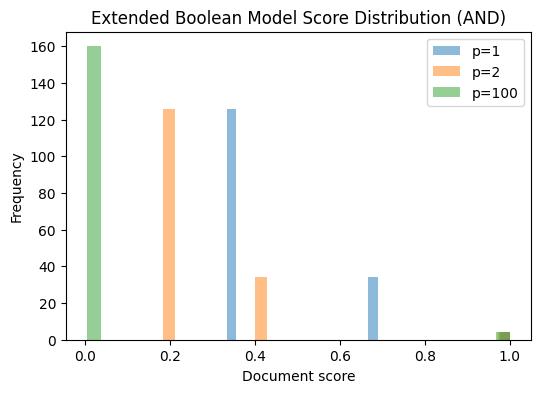


Retrieved document counts for query: (space AND shuttle) OR mission
+-----------+----------------------+
|   p value |   Retrieved Docs (#) |
+===========+======================+
|         1 |                  228 |
+-----------+----------------------+
|         2 |                  228 |
+-----------+----------------------+
|        10 |                  228 |
+-----------+----------------------+
|        50 |                  228 |
+-----------+----------------------+

Diagnostic results:
Minimal p for AND: 1
Minimal p for OR : None


In [22]:
import matplotlib.pyplot as plt
# ======================================
# PART 3: EXTENDED BOOLEAN MODEL (p-norm)
# ======================================
print("\n" + "="*60)
print("PART 3: EXTENDED BOOLEAN MODEL".center(90))
print("="*60)

# ------------------------------------------------------------
# building binary term-document matrix from inverted index
# ------------------------------------------------------------
def build_binary_matrix(inverted_index, total_docs):
    """
    Create a binary term-document incidence matrix.
    Each row = term, each column = document.
    Entry = 1 if term occurs in doc, else 0.
    """
    vocab = list(inverted_index.keys())
    vocab_index = {term: i for i, term in enumerate(vocab)}
    matrix = np.zeros((len(vocab), total_docs), dtype=np.float32)

    for term, docs in inverted_index.items():
        row = vocab_index[term]
        matrix[row, list(docs)] = 1.0
    return matrix, vocab, vocab_index

# Build matrix once
binary_matrix, vocab, vocab_index = build_binary_matrix(inverted_index,
                                                        len(preprocessed_docs))
total_docs = len(preprocessed_docs)

# ------------------------------------------------------------
# p-norm scoring functions
# ------------------------------------------------------------
def pnorm_or(query_terms, p=2):
    """
    Extended Boolean OR.
    s(d) = ( (1/|q|) * Σ_i (w_{i,d})^p )^(1/p)
    """
    weights = []
    for t in query_terms:
        if t in vocab_index:
            weights.append(binary_matrix[vocab_index[t]])
        else:
            weights.append(np.zeros(total_docs))
    if not weights:
        return np.zeros(total_docs)
    weights = np.stack(weights)
    scores = (np.mean(weights ** p, axis=0)) ** (1.0 / p)
    return scores

def pnorm_and(query_terms, p=2):
    """
    Extended Boolean AND.
    s(d) = 1 - ( (1/|q|) * Σ_i (1 - w_{i,d})^p )^(1/p)
    """
    weights = []
    for t in query_terms:
        if t in vocab_index:
            weights.append(binary_matrix[vocab_index[t]])
        else:
            weights.append(np.zeros(total_docs))
    if not weights:
        return np.zeros(total_docs)
    weights = np.stack(weights)
    scores = 1.0 - ((np.mean((1.0 - weights) ** p, axis=0)) ** (1.0 / p))
    return scores



# ------------------------------------------------------------
# 3. Nested AND/OR queries (tree-based)
# ------------------------------------------------------------
def eval_extended_boolean(query_structure, p=2):
    """
    Recursively evaluate extended Boolean queries with nested AND/OR.
    query_structure = ("AND", ["term1","term2",...]) or
                      ("OR",  ["term3","term4",...]) or
                      ("AND", [subquery,"term",...])
    """
    op, children = query_structure
    child_scores = []
    for child in children:
        if isinstance(child, tuple):   # nested subquery
            child_scores.append(eval_extended_boolean(child, p))
        else:  # leaf term
            if child in vocab_index:
                child_scores.append(binary_matrix[vocab_index[child]])
            else:
                child_scores.append(np.zeros(total_docs))
    W = np.stack(child_scores)

    if op == "AND":
        return 1.0 - (np.mean((1.0 - W) ** p, axis=0) ** (1.0 / p))
    elif op == "OR":
        return (np.mean(W ** p, axis=0)) ** (1.0 / p)
    else:
        raise ValueError("Unsupported operator: must be AND or OR")

# ------------------------------------------------------------
# Unified interface for comparison
# ------------------------------------------------------------
def extended_boolean_model(query, inverted_index, p_values=[1, 2, 10],
                           mode="AND"):
  """Compute document scores for several p values."""
  query_tokens = preprocess_text(query).split()
  if not query_tokens:
        return []

  results = []
  for p in p_values:
        if mode == "AND":
            scores = pnorm_and(query_tokens, p)
        elif mode == "OR":
            scores = pnorm_or(query_tokens, p)
        else:
            raise ValueError("mode must be 'AND' or 'OR'")

        nonzero = np.where(scores > 0)[0]
        ranked_docs = nonzero[np.argsort(-scores[nonzero])] if len(nonzero) > 0 else []
        results.append((p, scores, ranked_docs.tolist()))
  return results


# ------------------------------------------------------------
# Example query
# ------------------------------------------------------------
query = "NASA moon landing"
query_tokens = preprocess_text(query).split()
print(f"\nPreprocessed query tokens: {query_tokens}")

# Boolean baseline (from part 2)
boolean_docs = boolean_retrieve(" AND ".join(query_tokens), inverted_index,
                                total_docs)
print(f"\nBoolean Model Docs for '{query}': {boolean_docs[:15]}...")

# Compare Extended Boolean outputs
rows = []
results = extended_boolean_model(query, inverted_index, p_values=[1, 2, 100],
                                 mode="AND")
for p_val, scores, ranked_docs in results:
    rows.append([
        query,
        str(boolean_docs[:10]) + "...",
        f"Extended Boolean AND (p={p_val})",
        f"{ranked_docs[:10]}..."
    ])

print("\nComparison of Boolean vs. Extended Boolean (p-norm):")
print(tabulate(rows,
               headers=["Query", "Boolean Docs", "Model Type", "Top Docs (IDs)"],
               tablefmt="grid"))
# ------------------------------------------------------------
# 6.Visualization of p effect
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
for p_val, scores, _ in results:
    plt.hist(scores[scores>0], bins=30, alpha=0.5, label=f"p={p_val}")
plt.xlabel("Document score")
plt.ylabel("Frequency")
plt.title("Extended Boolean Model Score Distribution (AND)")
plt.legend()
plt.show()


# ------------------------------------------------------------
# 7. Ranking comparison across p values (show counts only)
# ------------------------------------------------------------
def compare_retrieved_counts(query_structure, p_values=[1,2,10,50]):
    rows = []
    for p in p_values:
        scores = eval_extended_boolean(query_structure, p)
        nonzero = np.where(scores > 0)[0]
        count = len(nonzero)
        rows.append([p, count])
    return rows

query_nested = ("OR", [
                   ("AND", ["space", "shuttle"]),
                   "mission"
               ])

rows = compare_retrieved_counts(query_nested, p_values=[1,2,10,50])
print("\nRetrieved document counts for query: (space AND shuttle) OR mission")
print(tabulate(rows, headers=["p value", "Retrieved Docs (#)"], tablefmt="grid"))


# ------------------------------------------------------------
# 8. Diagnostic: minimal p that matches Boolean sets
# ------------------------------------------------------------
def boolean_set(query_tokens, mode, inverted_index, total_docs):
    if mode == "AND":
        return set(boolean_retrieve(" AND ".join(query_tokens), inverted_index,
                                    total_docs))
    elif mode == "OR":
        return set(boolean_retrieve(" OR ".join(query_tokens), inverted_index,
                                    total_docs))
    else:
        raise ValueError("mode must be 'AND' or 'OR'")

def ranked_top_k(scores, k):
    if k == 0:
        return set()
    idx = np.argsort(-scores)
    return set(idx[:k])

def extended_scores(query_tokens, mode, p):
    return pnorm_and(query_tokens, p) if mode=="AND" else pnorm_or(query_tokens
                                                                   , p)

def find_min_p_for_boolean_equivalence(queries, mode="AND", p_grid=None):
    if p_grid is None:
        p_grid = [1,2,3,4,5,6,8,10,15,20,30,50,75,100]
    for p in p_grid:
        all_match = True
        for q in queries:
            q_tokens = preprocess_text(q).split()
            B = boolean_set(q_tokens, mode, inverted_index, total_docs)
            k = len(B)
            scores = extended_scores(q_tokens, mode, p)
            top = ranked_top_k(scores, k)
            if top != B:
                all_match = False
                break
        if all_match:
            return p
    return None

assignment_queries = [
    "space shuttle mission", "NASA moon landing", "satellite orbit earth",
    "astronomy telescope stars", "space exploration mars",
    "major league baseball", "world series game", "batting average players",
    "pitcher home run", "baseball team stadium",
    "3D graphics rendering", "image processing algorithm",
    "computer animation software", "ray tracing light",
    "video game graphics"
]

min_p_and = find_min_p_for_boolean_equivalence(assignment_queries, mode="AND")
min_p_or  = find_min_p_for_boolean_equivalence(assignment_queries, mode="OR")

print("\nDiagnostic results:")
print("Minimal p for AND:", min_p_and)
print("Minimal p for OR :", min_p_or)

# Part 4: Indexing & TF-IDF

In [31]:
# ======================================
# PART 4: INDEXING & TF-IDF
# ======================================

from collections import Counter
import math

print("\n" + "="*70)
print("PART 4: INDEXING & TF-IDF".center(70))
print("="*70)

# ------------------------------------------------------------
# 1. Build vocabulary
# ------------------------------------------------------------
tokenized_docs = [doc.split() for doc in preprocessed_docs]
vocab = sorted(set(term for doc in tokenized_docs for term in doc))
vocab_index = {term: i for i, term in enumerate(vocab)}
N = len(preprocessed_docs)

# ------------------------------------------------------------
# 2. Compute TF and DF
# ------------------------------------------------------------
TF = []  # list of Counters
DF = Counter()

for doc in tokenized_docs:
    counts = Counter(doc)
    TF.append(counts)
    for term in counts.keys():
        DF[term] += 1

# ------------------------------------------------------------
# 3. Compute IDF
# ------------------------------------------------------------
IDF = {term: math.log2((N) / (DF[term])) for term in vocab}  # smoothed

# ------------------------------------------------------------
# 4. Build TF-IDF matrix
# ------------------------------------------------------------
tfidf_matrix = np.zeros((N, len(vocab)), dtype=np.float32)

for doc_id, counts in enumerate(TF):
    for term, tf in counts.items():
        j = vocab_index[term]
        tfidf_matrix[doc_id, j] = tf * IDF[term]

print(f"TF-IDF matrix built: shape = {tfidf_matrix.shape}")

# ------------------------------------------------------------
# 5.Show TF, DF, IDF, and TF-IDF for sample terms across 8 docs
# ------------------------------------------------------------
raw_terms = ["space", "baseball", "graphics","satellite","orbit","earth",
                "astronomy","telescope","stars"]
doc_range = range(8)  # first 8 documents

# Build header
headers = ["Raw Term", "Processed Term", "DF", "IDF (log2)"] + [f"Doc{d}" for d in doc_range]

rows = []
for raw_term in raw_terms:
    term = preprocess_text(raw_term).strip()
    df = DF.get(term, 0)
    idf = round(IDF.get(term, 0), 3)
    row = [raw_term, term, df, idf]
    for doc_id in doc_range:
        tf = TF[doc_id][term] if term in TF[doc_id] else 0
        tfidf = round(tfidf_matrix[doc_id, vocab_index[term]], 3) if term in vocab_index else 0
        row.append(f"TF={tf}, TF-IDF={tfidf}")
    rows.append(row)

print("\nTF, DF, IDF, and TF-IDF values across first 8 documents:")
print(tabulate(rows, headers=headers, tablefmt="grid"))


                      PART 4: INDEXING & TF-IDF                       
TF-IDF matrix built: shape = (1774, 16560)

TF, DF, IDF, and TF-IDF values across first 8 documents:
+------------+------------------+------+--------------+------------------+--------------------------------+------------------+--------------------------------+------------------+------------------+-------------------------------+------------------+
| Raw Term   | Processed Term   |   DF |   IDF (log2) | Doc0             | Doc1                           | Doc2             | Doc3                           | Doc4             | Doc5             | Doc6                          | Doc7             |
+============+==================+======+==============+==================+================================+==================+================================+==================+==================+===============================+==================+
| space      | space            |  208 |        3.092 | TF=0, TF-IDF=0.0 | TF=0,

# Part 5: Vector Space Model


                      PART 5: VECTOR SPACE MODEL                      

Vector Space Model Retrieval Results:
+-------------------------+-------------------------------+-------------------------------------+
| Query                   | Top Docs (IDs)                | Cosine Similarities                 |
+=========================+===============================+=====================================+
| space mission shuttle   | [1760, 974, 403, 917, 1268]   | [0.349, 0.336, 0.314, 0.308, 0.287] |
+-------------------------+-------------------------------+-------------------------------------+
| baseball team stadium   | [127, 190, 1043, 1692, 1072]  | [0.324, 0.316, 0.287, 0.27, 0.256]  |
+-------------------------+-------------------------------+-------------------------------------+
| computer graphics image | [1427, 1590, 713, 1662, 1693] | [0.329, 0.312, 0.303, 0.24, 0.22]   |
+-------------------------+-------------------------------+-------------------------------------+
| major

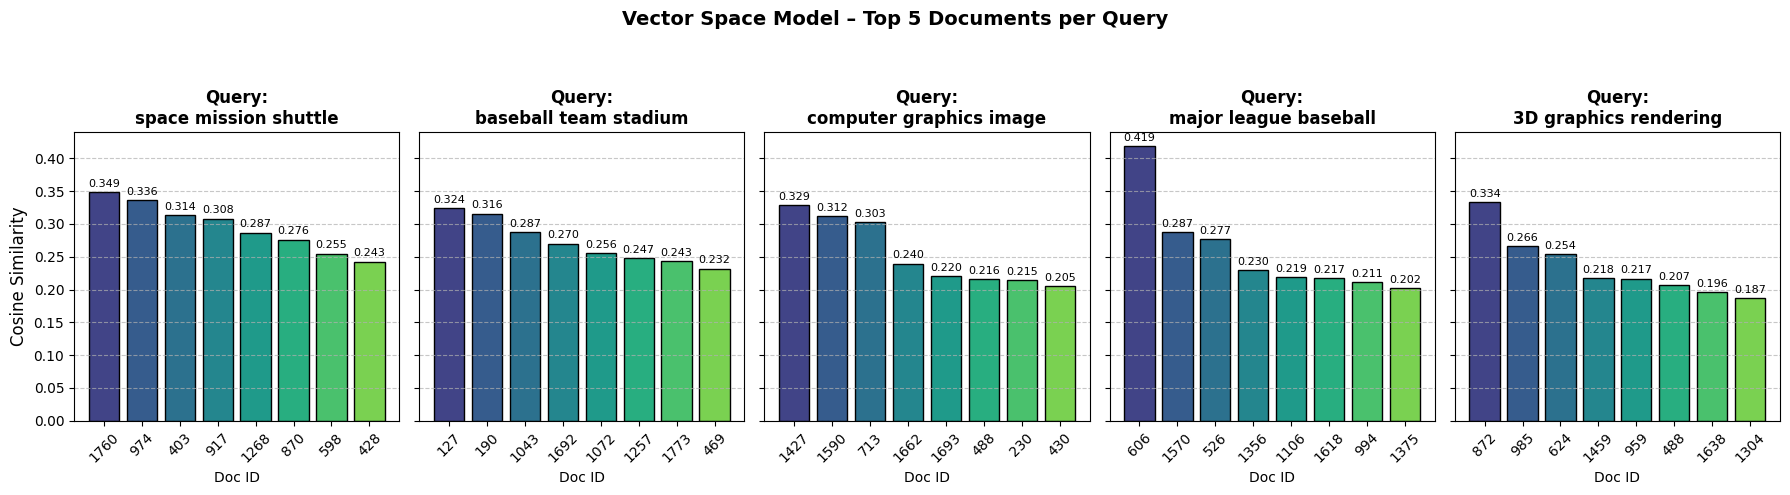

In [42]:
# ======================================
# PART 5: VECTOR SPACE MODEL (Cosine Similarity + Visualization)
# ======================================

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.cm as cm


print("\n" + "="*70)
print("PART 5: VECTOR SPACE MODEL".center(70))
print("="*70)

# ------------------------------------------------------------
# 1. Function to build query vector in TF-IDF space
# ------------------------------------------------------------
def build_query_vector(query, vocab_index, IDF):
    tokens = preprocess_text(query).split()
    counts = Counter(tokens)
    q_vec = np.zeros(len(vocab_index), dtype=np.float32)
    for term, tf in counts.items():
        if term in vocab_index:
            j = vocab_index[term]
            q_vec[j] = tf * IDF.get(term, 0)
    return q_vec.reshape(1, -1)  # shape (1, V)

# ------------------------------------------------------------
# 2. Function to run query against TF-IDF matrix
# ------------------------------------------------------------
def vector_space_retrieve(query, tfidf_matrix, vocab_index, IDF, top_k=10):
    q_vec = build_query_vector(query, vocab_index, IDF)
    sims = cosine_similarity(q_vec, tfidf_matrix)[0]  # shape (N,)
    ranked_docs = np.argsort(-sims)[:top_k]
    return ranked_docs, sims,q_vec,counts

# ------------------------------------------------------------
# 3. Example queries
# ------------------------------------------------------------
queries = [
    "space mission shuttle","baseball team stadium",
    "computer graphics image","major league baseball",
    "3D graphics rendering"
]

# ------------------------------------------------------------
# 4. Retrieval and Results Table
# ------------------------------------------------------------

rows = []
query_vectors = {}

for q in queries:
    ranked, sims, q_vec, counts = vector_space_retrieve(q, tfidf_matrix, vocab_index, IDF, top_k=5)

    ranked_py = np.asarray(ranked, dtype=int).tolist()
    scores_py = [float(sims[i]) for i in ranked_py]

    rows.append([
        q,
        str(ranked_py),
        str([round(s, 3) for s in scores_py])
    ])

    # save query vector info
    query_weights = [(term, round(q_vec[0, vocab_index[term]], 3)) for term in counts if term in vocab_index]
    query_weights = sorted(query_weights, key=lambda x: -x[1])  # sort by weight
    query_vectors[q] = query_weights

print("\nVector Space Model Retrieval Results:")
print(tabulate(rows,
               headers=["Query", "Top Docs (IDs)", "Cosine Similarities"],
               tablefmt="grid"))

# ------------------------------------------------------------
# 5. Visualization (side-by-side bar charts)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, len(queries), figsize=(18,5), sharey=True)

for ax, q in zip(axes, queries):
    ranked, sims, q_vec, counts = vector_space_retrieve(q, tfidf_matrix,
                                                        vocab_index, IDF,
                                                        top_k=8)

    ranked_py = np.asarray(ranked, dtype=int).tolist()
    scores_py = [float(sims[i]) for i in ranked_py]

    colors = cm.viridis(np.linspace(0.2, 0.8, len(ranked_py)))
    bars = ax.bar([str(i) for i in ranked_py], scores_py, color=colors,
                  edgecolor="black")

    # add value labels
    for bar, score in zip(bars, scores_py):
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.005,
                f"{score:.3f}",
                ha="center", va="bottom", fontsize=8)

    ax.set_title(f"Query:\n{q}", fontsize=12, weight="bold")
    ax.set_xlabel("Doc ID", fontsize=10)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    ax.tick_params(axis="x", rotation=45)

axes[0].set_ylabel("Cosine Similarity", fontsize=12)
plt.suptitle("Vector Space Model – Top 5 Documents per Query", fontsize=14,
             weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

# Part 6: Query Operations


                       PART 6: QUERY EXPANSION / RELEVANCE FEEDBACK                       

Original query:  space mission shuttle
Expanded query:  space mission shuttle orbit planetari nasa
Expansion terms: ['orbit', 'planetari', 'nasa']


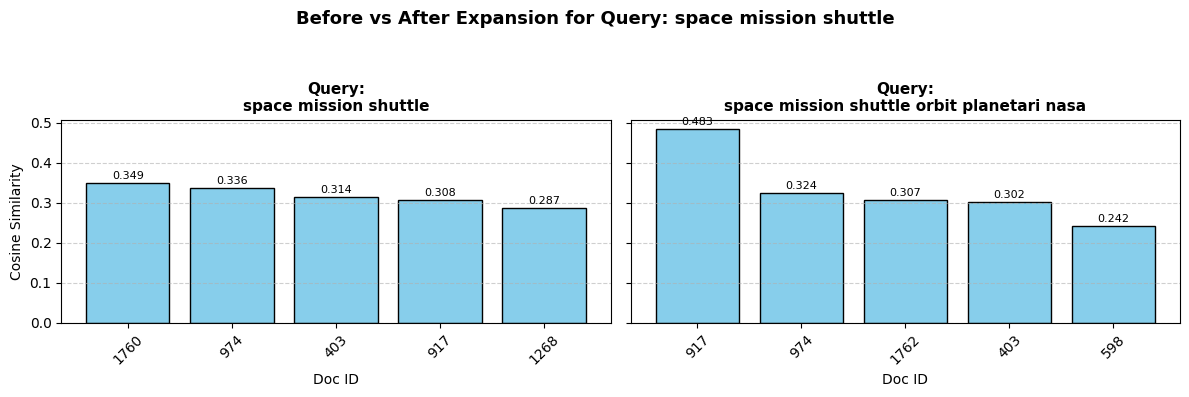


Original query:  baseball team stadium
Expanded query:  baseball team stadium shea seri multipurpos
Expansion terms: ['shea', 'seri', 'multipurpos']


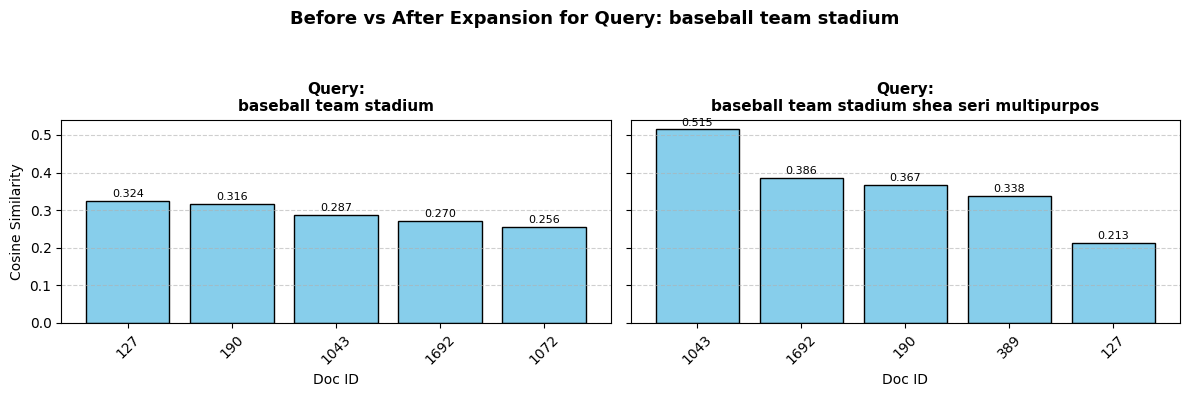


Original query:  computer graphics image
Expanded query:  computer graphics image tool process plot
Expansion terms: ['tool', 'process', 'plot']


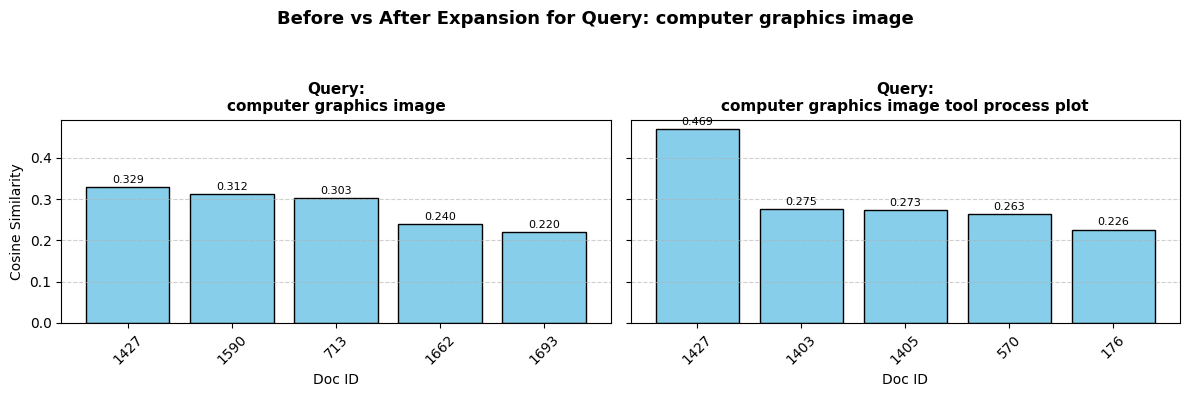


Original query:  major league baseball
Expanded query:  major league baseball player stat rush
Expansion terms: ['player', 'stat', 'rush']


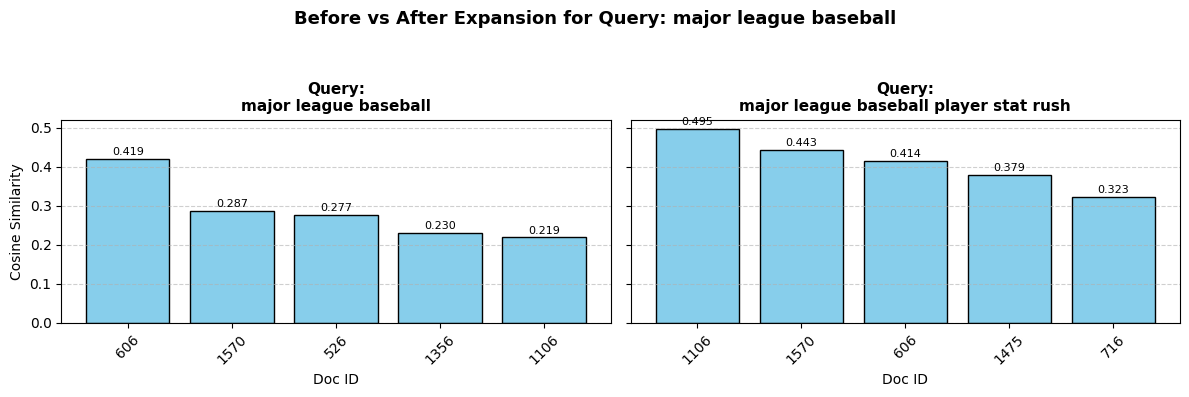


Original query:  3D graphics rendering
Expanded query:  3D graphics rendering outlin frame polygon
Expansion terms: ['outlin', 'frame', 'polygon']


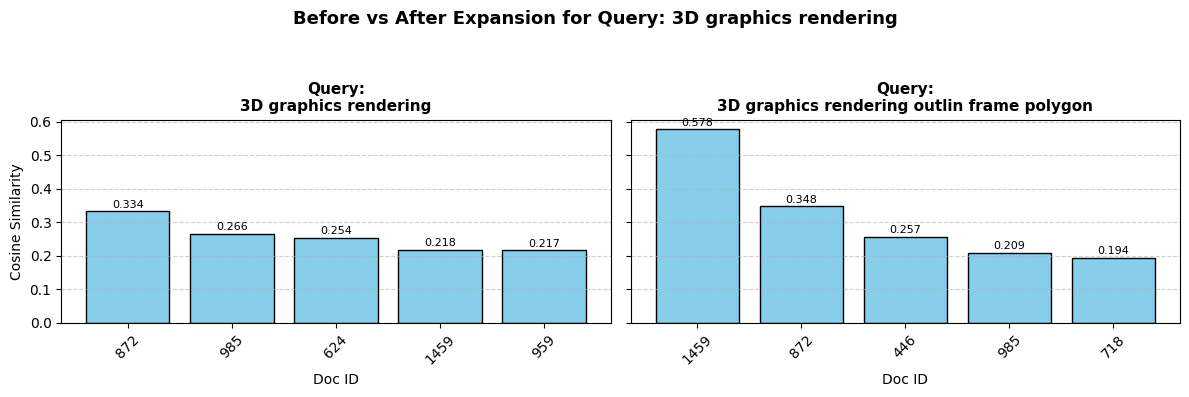


Retrieval Comparison (Before vs After Expansion):
+---------------------------------------------+-------------------------------+-------------------------------------+
| Query                                       | Top Docs (IDs)                | Cosine Similarities                 |
+=============================================+===============================+=====================================+
| space mission shuttle                       | [1760, 974, 403, 917, 1268]   | [0.349, 0.336, 0.314, 0.308, 0.287] |
+---------------------------------------------+-------------------------------+-------------------------------------+
| space mission shuttle orbit planetari nasa  | [917, 974, 1762, 403, 598]    | [0.483, 0.324, 0.307, 0.302, 0.242] |
+---------------------------------------------+-------------------------------+-------------------------------------+
| baseball team stadium                       | [127, 190, 1043, 1692, 1072]  | [0.324, 0.316, 0.287, 0.27, 0.256]  |
+----

In [45]:
# ======================================
# PART 6: QUERY EXPANSION
# ======================================

print("\n" + "="*90)
print("PART 6: QUERY EXPANSION / RELEVANCE FEEDBACK".center(90))
print("="*90)

# ------------------------------------------------------------
# 1. Function to expand query with top terms from top-N docs
# ------------------------------------------------------------
def expand_query(query, tfidf_matrix, vocab, vocab_index, IDF, top_docs=5,
                 expand_terms=3):
    ranked, sims, q_vec, counts = vector_space_retrieve(query, tfidf_matrix,
                                                        vocab_index, IDF,
                                                        top_k=top_docs)

    # collect TF-IDF scores from top docs
    candidate_scores = Counter()
    for doc_id in ranked:
        for term_idx in np.nonzero(tfidf_matrix[doc_id])[0]:
            term = vocab[term_idx]
            candidate_scores[term] += tfidf_matrix[doc_id, term_idx]

    # remove original query terms
    original_terms = set(preprocess_text(query).split())
    for t in original_terms:
        if t in candidate_scores:
            del candidate_scores[t]

    # pick top expand_terms
    expansion = [t for t, _ in candidate_scores.most_common(expand_terms)]
    expanded_query = query + " " + " ".join(expansion)
    return expanded_query, expansion

# ------------------------------------------------------------
# 2. Example queries
# ------------------------------------------------------------
queries = [
    "space mission shuttle","baseball team stadium","computer graphics image",
    "major league baseball", "3D graphics rendering"]

# ------------------------------------------------------------
# 3. Run expansion and retrieval for each query
# ------------------------------------------------------------
rows = []
for query in queries:
    expanded_query, expansion_terms = expand_query(query, tfidf_matrix, vocab,
                                                   vocab_index, IDF,
                                                   top_docs=5, expand_terms=3)

    print(f"\nOriginal query:  {query}")
    print(f"Expanded query:  {expanded_query}")
    print(f"Expansion terms: {expansion_terms}")

    # Compare retrieval before and after expansion
    results = {}
    for q in [query, expanded_query]:
        ranked, sims, q_vec, counts = vector_space_retrieve(q, tfidf_matrix,
                                                            vocab_index, IDF,
                                                            top_k=5)
        ranked_py = np.asarray(ranked, dtype=int).tolist()
        scores_py = [float(sims[i]) for i in ranked_py]
        results[q] = (ranked_py, scores_py)
        rows.append([q, str(ranked_py), str([round(s, 3) for s in scores_py])])

    # --- Visualization: Before vs After Expansion ---
    fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)

    for ax, q in zip(axes, [query, expanded_query]):
        ranked_py, scores_py = results[q]
        bars = ax.bar([str(i) for i in ranked_py], scores_py, color="skyblue",
                      edgecolor="black")
        for bar, score in zip(bars, scores_py):
            ax.text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.005,
                    f"{score:.3f}",
                    ha="center", va="bottom", fontsize=8)
        ax.set_title(f"Query:\n{q}", fontsize=11, weight="bold")
        ax.set_xlabel("Doc ID")
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        ax.tick_params(axis="x", rotation=45)

    axes[0].set_ylabel("Cosine Similarity")
    plt.suptitle(f"Before vs After Expansion for Query: {query}", fontsize=13,
                 weight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

# ------------------------------------------------------------
# 4. Show results table
# ------------------------------------------------------------
print("\nRetrieval Comparison (Before vs After Expansion):")
print(tabulate(rows, headers=["Query", "Top Docs (IDs)", "Cosine Similarities"],
               tablefmt="grid"))


# Part 7: Evaluation


                                PART 7: EVALUATION METRICS                                

Evaluation Results (Precision/Recall/F1/AP@10):
+-------------------------+--------------------+-----------------+-------------------------+-----------------------+----------------------+
| Query                   | Category           | Boolean         | Extended Boolean        | VSM                   | VSM+Expansion        |
+=========================+====================+=================+=========================+=======================+======================+
| space mission shuttle   | sci.space          | 0.0/0.0/0.0/0.0 | 0.333/0.002/0.003/0.333 | 1.0/0.017/0.033/1.0   | 1.0/0.017/0.033/1.0  |
+-------------------------+--------------------+-----------------+-------------------------+-----------------------+----------------------+
| baseball team stadium   | rec.sport.baseball | 0.0/0.0/0.0/0.0 | 0.1/0.002/0.003/0.25    | 1.0/0.017/0.033/1.0   | 0.9/0.015/0.03/0.906 |
+------------------

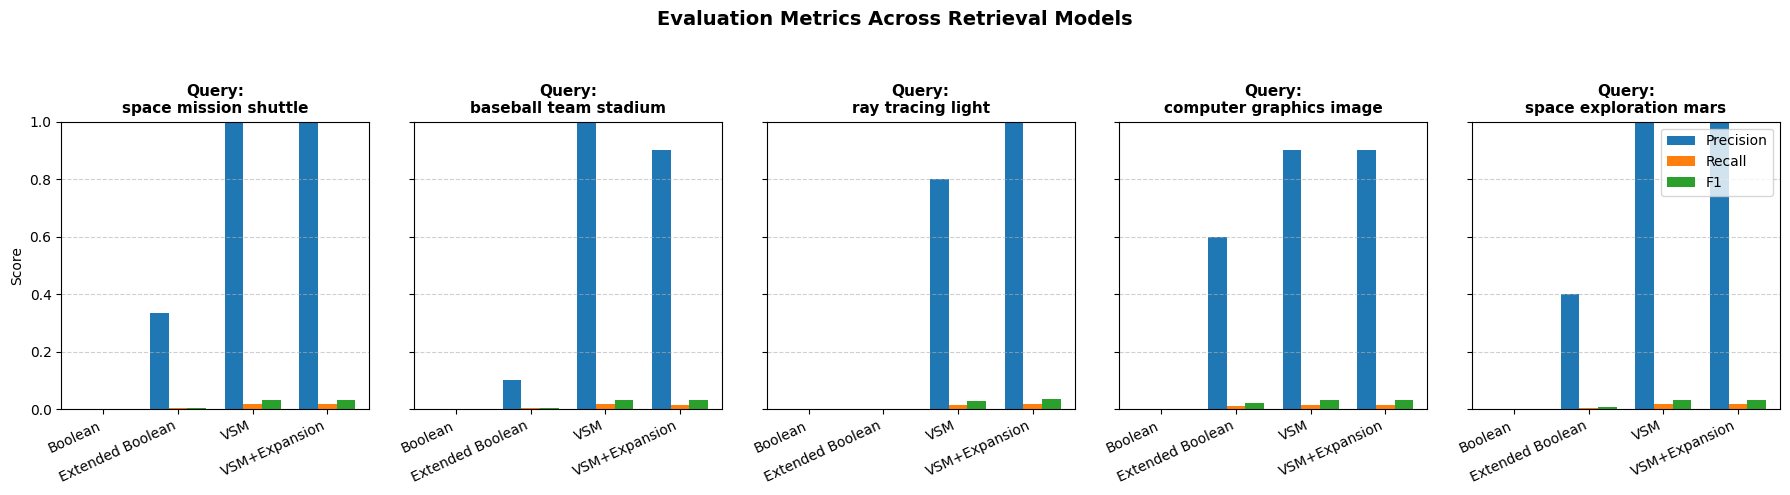

In [55]:
# ======================================
# PART 7: EVALUATION (Precision, Recall, F1, AP, MAP)
# ======================================
print("\n" + "="*90)
print("PART 7: EVALUATION METRICS".center(90))
print("="*90)
label_names = data.target_names
true_labels = data.target
# ------------------------------------------------------------
# 1. Utilities for evaluation
# ------------------------------------------------------------
def average_precision_at_k(retrieved_docs, category, k=10):
    """Average Precision at k for one query."""
    category_id = label_names.index(category)
    relevant = 0
    ap_sum = 0.0
    for i, doc in enumerate(retrieved_docs[:k], start=1):
        if true_labels[doc] == category_id:
            relevant += 1
            ap_sum += relevant / i
    return ap_sum / relevant if relevant > 0 else 0.0

def evaluate_retrieval_with_ap(retrieved_docs, category, k=10):
    """Compute Precision, Recall, F1, AP@k."""
    category_id = label_names.index(category)
    relevant_docs = [i for i, lbl in enumerate(true_labels) if lbl == category_id]
    retrieved_k = retrieved_docs[:k]
    retrieved_relevant = [doc for doc in retrieved_k if true_labels[doc] == category_id]

    precision = len(retrieved_relevant) / len(retrieved_k) if retrieved_k else 0.0
    recall = len(retrieved_relevant) / len(relevant_docs) if relevant_docs else 0.0
    f1 = (2 * precision * recall) / (precision + recall) if precision+recall > 0 else 0.0
    ap = average_precision_at_k(retrieved_docs, category, k=k)
    return round(precision,3), round(recall,3), round(f1,3), round(ap,3)

# ------------------------------------------------------------
# 2. Queries and expected categories
# ------------------------------------------------------------
queries = [
    "space mission shuttle",
    "baseball team stadium","ray tracing light",
    "computer graphics image","space exploration mars"
]
query_category_map = {
    "space mission shuttle": "sci.space",
    "baseball team stadium": "rec.sport.baseball",
    "computer graphics image": "comp.graphics",
    "space exploration mars": "sci.space",
    "ray tracing light": "comp.graphics"
}

# ------------------------------------------------------------
# 3. Evaluate each model
# ------------------------------------------------------------
models = ["Boolean", "Extended Boolean", "VSM", "VSM+Expansion"]
per_query_rows = []
map_accumulator = {m: [] for m in models}
eval_results = {}
k_eval = 10

for q in queries:
    cat = query_category_map[q]

    # Boolean
    retrieved_bool = boolean_retrieve(q, inverted_index, total_docs)
    p_b, r_b, f_b, ap_b = evaluate_retrieval_with_ap(retrieved_bool, cat, k=k_eval)
    map_accumulator["Boolean"].append(ap_b)

    # Extended Boolean (AND, p=10)
    tokens = preprocess_text(q).split()
    scores_ext = pnorm_and(tokens, p=10)
    nonzero = np.where(scores_ext > 0)[0]
    ranked_ext = nonzero[np.argsort(-scores_ext[nonzero])].tolist()
    p_e, r_e, f_e, ap_e = evaluate_retrieval_with_ap(ranked_ext, cat, k=k_eval)
    map_accumulator["Extended Boolean"].append(ap_e)

    # VSM
    ranked_vsm, sims, _, _ = vector_space_retrieve(q, tfidf_matrix, vocab_index, IDF, top_k=k_eval)
    ranked_vsm = np.asarray(ranked_vsm, dtype=int).tolist()
    p_v, r_v, f_v, ap_v = evaluate_retrieval_with_ap(ranked_vsm, cat, k=k_eval)
    map_accumulator["VSM"].append(ap_v)

    # VSM + Expansion
    expanded_q, _ = expand_query(q, tfidf_matrix, vocab, vocab_index, IDF, top_docs=5, expand_terms=3)
    ranked_exp, sims, _, _ = vector_space_retrieve(expanded_q, tfidf_matrix, vocab_index, IDF, top_k=k_eval)
    ranked_exp = np.asarray(ranked_exp, dtype=int).tolist()
    p_qe, r_qe, f_qe, ap_qe = evaluate_retrieval_with_ap(ranked_exp, cat, k=k_eval)
    map_accumulator["VSM+Expansion"].append(ap_qe)

    per_query_rows.append([
        q, cat,
        f"{p_b}/{r_b}/{f_b}/{ap_b}",
        f"{p_e}/{r_e}/{f_e}/{ap_e}",
        f"{p_v}/{r_v}/{f_v}/{ap_v}",
        f"{p_qe}/{r_qe}/{f_qe}/{ap_qe}"
    ])

    eval_results[q] = {
        "Boolean": (p_b, r_b, f_b),
        "Extended Boolean": (p_e, r_e, f_e),
        "VSM": (p_v, r_v, f_v),
        "VSM+Expansion": (p_qe, r_qe, f_qe)
    }

# ------------------------------------------------------------
# 4. Print results
# ------------------------------------------------------------
print("\nEvaluation Results (Precision/Recall/F1/AP@10):")
print(tabulate(per_query_rows,
               headers=["Query","Category","Boolean","Extended Boolean","VSM","VSM+Expansion"],
               tablefmt="grid"))

# ------------------------------------------------------------
# 5. MAP summary
# ------------------------------------------------------------
map_rows = [[m, round(np.mean(vals),3) if vals else 0.0] for m, vals in map_accumulator.items()]
print("\nMean Average Precision (MAP@10):")
print(tabulate(map_rows, headers=["Model","MAP@10"], tablefmt="grid"))

# ------------------------------------------------------------
# 6. Visualization: Precision, Recall, F1 across models
# ------------------------------------------------------------
fig, axes = plt.subplots(1, len(queries), figsize=(18,5), sharey=True)
for ax, q in zip(axes, queries):
    values = [eval_results[q][m] for m in models]  # [(p,r,f), ...]
    values = np.array(values)

    x = np.arange(len(models))
    width = 0.25

    ax.bar(x - width, values[:,0], width, label="Precision")
    ax.bar(x, values[:,1], width, label="Recall")
    ax.bar(x + width, values[:,2], width, label="F1")

    ax.set_title(f"Query:\n{q}", fontsize=11, weight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=25, ha="right")
    ax.set_ylim(0,1)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

axes[0].set_ylabel("Score")
plt.suptitle("Evaluation Metrics Across Retrieval Models", fontsize=14, weight="bold")
plt.legend(loc="upper right")
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()
